# E.1 Imports

In [1]:
# set current path to the parent, to enable absolute imports 

import os
from pathlib import Path

curr_path = Path(os.getcwd()).parent
os.chdir(curr_path)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import torch
import seaborn as sns
import sqlite3
import sqlalchemy
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
import random

from torch.utils.data import DataLoader, RandomSampler
from torch.optim import Adam
from torch.nn import MSELoss
import math
from torch.utils.data import SequentialSampler
from transformers import BertForSequenceClassification

from main.active_learning.utils import seed_pool_split, experiment_AL
from main.active_learning.datasets import ALDataset

C:\Users\sebastian.keil\Anaconda3\envs\ai_thesis\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# E.2 Data Loading and Prep

In [3]:
# put device onto GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')
if torch.cuda.is_available():
  print(f"GPU name: {torch.cuda.get_device_name()}")


Using device: cpu


In [4]:
# read in: first 200 labeled instances
# toDO: read in more data

sent_df = pd.read_csv('files/datasets/labeled/l01_reuters_sample200.csv')

In [5]:
# drop the miscellaneous instances

sent_df = sent_df[sent_df['is_miscellaneous'] == False]

In [6]:
# extract sentences and valence/arousal labels as numpy arrays

sentences = sent_df.sentence.values
v_labels = sent_df.valence.values
a_labels = sent_df.arousal.values

In [7]:
# toDO: check what else we can do with tokenization
# e.g. add financial words to the vocabulary
# e.g. take another pre-trained tokenizer model

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [8]:

# measure the maximum sentence length
# this is needed for adjusting the BERT size later


max_len = 0
# For every sentence...
for sent in sentences:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))
print('Max sentence length: ', max_len)


Max sentence length:  62


In [9]:

# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
        sent,  # Sentence to encode.
        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
        max_length=75,  # Pad & truncate all sentences.
        padding='max_length',
        return_attention_mask=True,  # Construct attn. masks.
        return_tensors='pt',  # Return pytorch tensors.
    )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

v_labels = torch.tensor(v_labels)
a_labels = torch.tensor(a_labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])
print('Valence: ', v_labels[0])
print('Arousal: ', a_labels[0])


Original:  The automaker also said it is considering introducing subcompact SUV models in South Korea, the United States and Europe.
Token IDs: tensor([  101,  1996,  8285,  8571,  2036,  2056,  2009,  2003,  6195, 10449,
         4942,  9006, 19498,  2102, 15620,  4275,  1999,  2148,  4420,  1010,
         1996,  2142,  2163,  1998,  2885,  1012,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0])
Valence:  tensor(0.6400, dtype=torch.float64)
Arousal:  tensor(0.5100, dtype=torch.float64)


# E.3 Main Experiment

In [10]:
# set all the random seeds

RANDOM_STATE = 42 
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)

In [11]:
# experiment parameters

TRAIN_SIZE = 0.75
methods = ['random', 'farthest-first', 'mc-dropout']
batch_sizes = [3]  # 4,
lrs = [1e-6]  # 1e-5

In [19]:
# initiate results storage for valence and arousal models

v_results, a_results = {}, {}

In [20]:
# loop over all batch_sizes
for batch_size in batch_sizes:
    
    # initiate storage in dictionary, in a nested manner
    v_results[batch_size], a_results[batch_size] = {}, {}
    
    # loop over all the learning rates 
    for lr in lrs:
        
        # initiate storage in dictionary, in a nested manner
        v_results[batch_size][lr], a_results[batch_size][lr] = {}, {}
        
        # loop over all the methods
        for method in methods:
            
            # initiate storage in dictionary, in a nested manner
            v_results[batch_size][lr][method], a_results[batch_size][lr][method] = {}, {}
        
            # print out modifications of this experiment loop
            print("--" * 20)
            print(f"METHOD: {method}. BATCH SIZE: {batch_size}. LEARNING RATE: {lr} ")
            print("--" * 20)

            # seperate 25% for testing, 75% training
            v_train_ds, v_test_ds = seed_pool_split(input_ids, attention_masks, v_labels, seed_size=TRAIN_SIZE,
                                                    random_state=RANDOM_STATE)
            a_train_ds, a_test_ds = seed_pool_split(input_ids, attention_masks, a_labels, seed_size=TRAIN_SIZE,
                                                    random_state=RANDOM_STATE)

            # initiate seed and pool
            v_seed, v_pool = seed_pool_split(v_train_ds[0], v_train_ds[1], v_train_ds[2], seed_size=batch_size,
                                             random_state=RANDOM_STATE)
            a_seed, a_pool = seed_pool_split(a_train_ds[0], a_train_ds[1], a_train_ds[2], seed_size=batch_size,
                                             random_state=RANDOM_STATE)

            #v_results[method], a_results[method] = {}, {}
            #v_results[method][batch_size], a_results[method][batch_size] = {}, {}

            # download valence and arousal base models
            print("Downloading Valence model...")
            torch.manual_seed(42)
            v_model = BertForSequenceClassification.from_pretrained(
                'bert-base-uncased',
                num_labels=1,
                output_attentions=False,
                output_hidden_states=True)

            print("Downloading Arousal model...")
            torch.manual_seed(42)
            a_model = BertForSequenceClassification.from_pretrained(
                'bert-base-uncased',
                num_labels=1,
                output_attentions=False,
                output_hidden_states=True)

            # initialize Active Learning datasets
            v_seed_ds, v_pool_ds = ALDataset(v_seed[0], v_seed[1], v_seed[2]), ALDataset(v_pool[0], v_pool[1],
                                                                                         v_pool[2])

            a_seed_ds, a_pool_ds = ALDataset(a_seed[0], a_seed[1], a_seed[2]), ALDataset(a_pool[0], a_pool[1],
                                                                                         a_pool[2])

            # take a subsample only
            SAMPLE_SIZE = 12
            RANDOM_SEED = 42
            v_pool_ds = v_pool_ds.subsample(SAMPLE_SIZE, RANDOM_SEED)
            a_pool_ds = a_pool_ds.subsample(SAMPLE_SIZE, RANDOM_SEED)

            print("Valence Sample Pool Size: ", len(v_pool_ds), "Arousal Sample Pool Size: ", len(a_pool_ds))

            # initate testsets
            v_test_set = TensorDataset(v_test_ds[0], v_test_ds[1], v_test_ds[2])
            a_test_set = TensorDataset(a_test_ds[0], a_test_ds[1], a_test_ds[2])

            # start the experiments
            print("--" * 20)
            print("RUNNING VALENCE EXPERIMENT")
            print("--" * 20)
            v_train_rmse_curve, v_test_loss_curve = experiment_AL(v_seed_ds, v_pool_ds, v_test_set, v_model, method, lr,
                                                                  batch_size, device)

            print("--" * 20)
            print("RUNNING AROUSAL EXPERIMENT")
            print("--" * 20)
            a_train_rmse_curve, a_test_loss_curve = experiment_AL(a_seed_ds, a_pool_ds, a_test_set, a_model, method, lr,
                                                                  batch_size, device)

            # store results
            v_results[batch_size][lr][method]['train'], v_results[batch_size][lr][method]['test'] = v_train_rmse_curve, v_test_loss_curve
            a_results[batch_size][lr][method]['train'], a_results[batch_size][lr][method]['test'] = a_train_rmse_curve, a_test_loss_curve
            

#             # append the results to dict
#             v_results[method][batch_size][f'train_{lr}'], v_results[method][batch_size][
#                 f'test_{lr}'] = v_train_rmse_curve, v_test_loss_curve
#             a_results[method][batch_size][f'train_{lr}'], a_results[method][batch_size][
#                 f'test_{lr}'] = a_train_rmse_curve, a_test_loss_curve

#             # write results into txt file
#             with open('experiment_results03.txt', 'a') as f:
#                 f.write(f'v_train_{method}_lr_{lr}_bs_{batch_size}, {v_train_rmse_curve} \n')
#                 f.write(f'v_test_{method}_lr_{lr}_bs_{batch_size}, {v_test_loss_curve} \n')
#                 f.write(f'a_train_{method}_lr_{lr}_bs_{batch_size}, {a_train_rmse_curve} \n')
#                 f.write(f'a_test_{method}_lr_{lr}_bs_{batch_size}, {a_test_loss_curve} \n')
#             f.close()


----------------------------------------
METHOD: random. BATCH SIZE: 3. LEARNING RATE: 1e-06 
----------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Valence Sample Pool Size:  12 Arousal Sample Pool Size:  12
----------------------------------------
RUNNING VALENCE EXPERIMENT
----------------------------------------
Total number of batches in the pool:  4
 Finding batch 1/4...
Current pool size:  12
Seed Size: 3 instances
Average RMSE:  0.22626662391723262
Average test RMSE: 0.4757045421008195
Method: random. Chosen indices: [ 1  3 10]
 Finding batch 2/4...
Current pool size:  9
Seed Size: 6 instances
Average RMSE:  0.16114398717579023
Average test RMSE: 0.4222540446275488
Method: random. Chosen indices: [8 0 4]
 Finding batch 3/4...
Current pool size:  6
Seed Size: 9 instances
Average RMSE:  0.15864969943399015
Average test RMSE: 0.33573818892986085
Method: random. Chosen indices: [1 4 3]
 Finding batch 4/4...
Current pool size:  3
Seed Size: 12 instances
Average RMSE:  0.12396969589664775
Average test RMSE: 0.21514527791006052
Method: random. Chosen indices: [0 1 2]
----------------------------------------
RUNNING AROUSAL EXPERIM

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Valence Sample Pool Size:  12 Arousal Sample Pool Size:  12
----------------------------------------
RUNNING VALENCE EXPERIMENT
----------------------------------------
Total number of batches in the pool:  4
 Finding batch 1/4...
Current pool size:  12
Seed Size: 3 instances
Average RMSE:  0.22626662391723262
Average test RMSE: 0.4757045421008195
Number of embedding vectors:  3
Number of embedding vectors:  12
Method: farthest-first. Chosen indices: [ 6 11  8]
 Finding batch 2/4...
Current pool size:  9
Seed Size: 6 instances
Average RMSE:  0.16635006874757188
Average test RMSE: 0.4236282102437471
Number of embedding vectors:  6
Number of embedding vectors:  9
Method: farthest-first. Chosen indices: [2 0 6]
 Finding batch 3/4...
Current pool size:  6
Seed Size: 9 instances
Average RMSE:  0.14777621745857483
Average test RMSE: 0.3353815503915579
Number of embedding vectors:  9
Number of embedding vectors:  6
Method: farthest-first. Chosen indices: [0 4 2]
 Finding batch 4/4...
Current 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Valence Sample Pool Size:  12 Arousal Sample Pool Size:  12
----------------------------------------
RUNNING VALENCE EXPERIMENT
----------------------------------------
Total number of batches in the pool:  4
 Finding batch 1/4...
Current pool size:  12
Seed Size: 3 instances
Average RMSE:  0.22626662391723262
Average test RMSE: 0.4757045421008195
Method: mc-dropout. Chosen indices: [ 9  5 11]
 Finding batch 2/4...
Current pool size:  9
Seed Size: 6 instances
Average RMSE:  0.19901916841081682
Average test RMSE: 0.4285452754258308
Method: mc-dropout. Chosen indices: [0 1 8]
 Finding batch 3/4...
Current pool size:  6
Seed Size: 9 instances
Average RMSE:  0.1682965909831908
Average test RMSE: 0.34373704796072296
Method: mc-dropout. Chosen indices: [0 3 5]
 Finding batch 4/4...
Current pool size:  3
Seed Size: 12 instances
Average RMSE:  0.1346946803219585
Average test RMSE: 0.22636836823841539
Method: mc-dropout. Chosen indices: [2 0 1]
----------------------------------------
RUNNING A

In [21]:
v_results

{3: {1e-06: {'random': {'train': [0.22626662391723262,
     0.16114398717579023,
     0.15864969943399015,
     0.12396969589664775],
    'test': [0.4757045421008195,
     0.4222540446275488,
     0.33573818892986085,
     0.21514527791006052]},
   'farthest-first': {'train': [0.22626662391723262,
     0.16635006874757188,
     0.14777621745857483,
     0.1340044800495909],
    'test': [0.4757045421008195,
     0.4236282102437471,
     0.3353815503915579,
     0.2075947526159594]},
   'mc-dropout': {'train': [0.22626662391723262,
     0.19901916841081682,
     0.1682965909831908,
     0.1346946803219585],
    'test': [0.4757045421008195,
     0.4285452754258308,
     0.34373704796072296,
     0.22636836823841539]}}}}

In [77]:
# produce graph


def plot_al_results(v_results, a_results, batch_size, lr):

    fig = plt.figure(figsize=(16,10))

    gs = fig.add_gridspec(nrows=2, ncols=2, hspace=0.05, wspace=0.05)

    axs = gs.subplots(sharex=True)


    for i, method in enumerate(v_results[batch_size][lr].keys()):
        axs[0, 0].plot(v_results[batch_size][lr][method]['train'], label=method)
        axs[1, 0].plot(v_results[batch_size][lr][method]['test'], label=method)
        axs[0, 0].legend(); axs[1, 0].legend()
        axs[0, 0].grid(); axs[1, 0].grid()

        axs[0,0].set_title('Valence')
        axs[0,0].set_ylabel('Training')
        axs[1,0].set_ylabel('Testing')

    for i, method in enumerate(a_results[batch_size][lr].keys()):
        axs[0, 1].plot(a_results[batch_size][lr][method]['train'], label=method)
        axs[1, 1].plot(a_results[batch_size][lr][method]['test'], label=method)
        axs[0, 1].legend(); axs[1, 1].legend()
        axs[0, 1].yaxis.tick_right(); axs[1, 1].yaxis.tick_right()
        axs[0, 1].grid(); axs[1, 1].grid()

        axs[0, 1].set_title('Arousal')

    fig.text(0.5, 0.07, 'Number of Epochs', ha='center')
    fig.text(0.05, 0.5, 'RMSE', ha='center', va='center', rotation='vertical')

    plt.savefig(f'files/results/active_learning_experiments/al_exp_batch_size_{batch_size}_learning_rate_{lr}.png')
    plt.show()



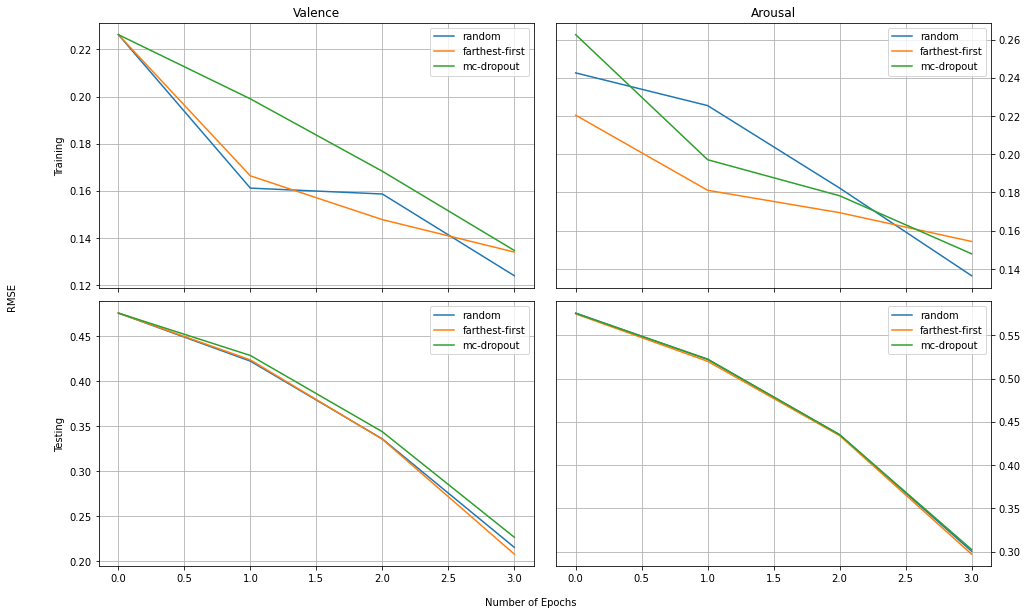

In [78]:
plot_al_results(v_results, a_results, 3, 1e-06)